现在，我们可以搭建同时建模截面关系和时序关系的复合transformer架构了

In [12]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import optuna
import math

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from modules import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

我们需要重新定义encoder层，现在encoder层需要两次注意力关注，一次在时序上，关注本资产的前后序列；另一次在截面上，关注同时期的其他资产。

为什么不在整个回望窗口内进行一个大的注意力机制呢？因为复杂度问题，假设资产数是 M 时间步是 N 全局注意力的开销是 O (MN)^2

而时序和截面相当于是进行了两次稀疏注意力，且都是是具有比较强的可解释性的：分析一个时间点的信息，看一看前后和同时间点的其他资产，肯定比看不同时间的不同资产更重要吧？

那如果确实有滞后信息需要传递呢？假设真的存在某种滞后关系，例如资产A的价格波动会在10天之后传导到B，这种机制也会被多层注意力捕获，因为我们的encoder层也是多层重叠的。第一次A的资产波动会传导到10天后的A，第二次则会从10天后的A传到到10天后的B，从而完成这种滞后效应的建模

In [13]:
from modules.attention import MultiHeadAttention
from modules.addnorm import AddNorm
from modules.ffn import PositionWiseFFN

class PanelEncoderBlock(nn.Module):
    """
    Panel data transformer
    """
    def __init__(self, d_model, num_head, num_ffn_hidden, dropout):
        super().__init__()
        # 纵向时间序列注意力；
        self.time_series_attention = MultiHeadAttention(d_model, num_head)
        # 横向截面注意力；
        self.cross_section_attention = MultiHeadAttention(d_model, num_head)
        # addnorm 层
        self.addnorm = AddNorm(normalized_shape=(d_model,), dropout=dropout)
        # 通过ffn 整合信息
        self.ffn = PositionWiseFFN(d_model, num_ffn_hidden, d_model)

    def forward(self, x, mask=None):
        """
        imput and output size: (batch_size, num_assets, seq_len or num_patch, d_model)
        """
        # 注意力机制会自动展平前面的层，把倒数第二层作为注意力的范围。对于时序注意力，倒数第二维度应该是时间步长度
        ts_out = self.time_series_attention(x,x,x, mask)
        ts_out = self.addnorm(x, ts_out)

        ts_out = ts_out.permute(0,2,1,3)# 这里交换num_assets 和 seq_len 来把资产数交换到倒数第二个维度上，让注意力关注截面
        cs_out = self.cross_section_attention(ts_out,ts_out,ts_out, mask)
        cs_out = cs_out.permute(0,2,1,3)# 记得交换回来
        cs_out = self.addnorm(x, cs_out)
        
        # 最后通过ffn 整理当前时间步内部的信息
        ffn_out = self.ffn(cs_out)
        ffn_out = self.addnorm(x, ffn_out)
        return ffn_out


In [14]:
class MultiLayerPanelEncoder(nn.Module):
    """
    多层PanelEncoder，由多个PanelEncoderBlock堆叠而成
    """
    def __init__(self, num_layer, d_model, num_head, num_ffn_hidden, dropout):
        super().__init__()
        self.layers = nn.ModuleList([PanelEncoderBlock(d_model = d_model, num_head = num_head,num_ffn_hidden = num_ffn_hidden,dropout = dropout,)for _ in range(num_layer)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

相比于预测单个资产，现在我们要预测一组资产

为什么不选用经典transformer的加性位置编码呢？原因有两个，加性位置编码的优点是节省维度，但缺点是模型需要首先学会从汇总的信息中分离位置信息和原始信息。

但是我们的时序预测维度并不高，不需要节省维度，反而我们的数据量是不足的，没必要浪费额外的成本来训练这个，因此采用concate的位置编码更好。

In [15]:
import torch
import torch.nn as nn
import math

class TemporalEmbedding(nn.Module):
    """
    Time2Vec时序编码，以concat形式扩展位置编码。
    原始输入维度: (*, seq_len, d_model)
    输出维度: (*, seq_len, d_model + dim_embedding)
    """
    def __init__(self, dim_embedding):
        super().__init__()
        self.dim_embedding = dim_embedding
        
        # Time2Vec 的可学习参数
        self.w = nn.Parameter(torch.empty(1, self.dim_embedding), requires_grad=True)
        self.b = nn.Parameter(torch.empty(1, self.dim_embedding), requires_grad=True)
        # 初始化参数
        nn.init.uniform_(self.w, -0.1, 0.1)
        nn.init.uniform_(self.b, -0.1, 0.1)

    def forward(self, x):
        """
        输入形状为 (*, seq_len, d_model)
        输出形状为 (*, seq_len, d_model + dim_embedding)
        """
        # 保存初始形状
        original_shape = x.shape # (*, seq_len, feature_dim)
        seq_len = original_shape[-2]
        batch_dims = original_shape[:-2]
        
        # 相对时间序号： [0, 1, 2, ..., seq_len-1]
        tau = torch.arange(seq_len, dtype=torch.float, device=x.device).unsqueeze(-1)

        # 计算时间嵌入
        time_embedding = tau @ self.w + self.b
        
        linear_part = time_embedding[:, :1] # 线性部分
        periodic_part = torch.sin(time_embedding[:, 1:]) # 周期性部分

        time_embedding = torch.cat([linear_part, periodic_part], dim=-1)

        # 把编码广播到所有维度
        target_shape = batch_dims + (seq_len, self.dim_embedding)
        time_embedding = time_embedding.expand(target_shape)

        # 拼接
        output = torch.cat([x, time_embedding], dim=-1)
        
        return output


Panel_Transformer 的主体部分，在不同任务之间通用

In [16]:
class PanelTransformerBackbone(nn.Module):
    def __init__(self, dim_patch_feature, dim_projection, dim_temporal_embedding, dim_assets_embedding, num_bass_assets, num_head, num_layer, dropout):
        super().__init__()
        dim_encoder_input = dim_projection +  dim_temporal_embedding + dim_assets_embedding
        self.projection = nn.Linear(dim_patch_feature, dim_projection)
        self.assets_embedding = AssetsEmbedding(num_base_assets = num_bass_assets, embedding_dim = dim_assets_embedding, target_ratio = 0.2, freeze = True)
        self.temporal_embedding = TemporalEmbedding(dim_embedding = dim_temporal_embedding)
        self.panel_encoder = MultiLayerPanelEncoder(num_layer = num_layer, d_model = dim_encoder_input, num_head = num_head, num_ffn_hidden = dim_encoder_input * 2, dropout = dropout)

    def forward(self, x, weights):
        x = self.projection(x)
        x = self.temporal_embedding(x)
        x = self.assets_embedding(x, weights)
        x = self.panel_encoder(x)
        return x

model = PanelTransformerBackbone(dim_patch_feature = 120, dim_projection = 128, dim_temporal_embedding = 38, dim_assets_embedding = 10, num_bass_assets = 53, num_head = 8, num_layer = 3 , dropout = 0.5)
model.assets_embedding.load_state_dict(torch.load('params/assets_embedding.params'))

<All keys matched successfully>

预训练层

In [17]:
class PretrainPanelTransformer(nn.Module):
    """Panel Time Series Transformer"""
    def __init__(self, dim_raw_feature, patch_size, stride, mask_expand_size, seq_len, dim_projection, dim_temporal_embedding, dim_assets_embedding, num_bass_assets, num_head, num_layer, dropout):
        super().__init__()
        # 模型参数
        self.device = 'cuda:0'
        self.input_size = dim_raw_feature
        self.patch_size = patch_size
        self.stride = stride
        self.mask_expand_size = mask_expand_size
        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        self.dim_projection = dim_projection

        dim_encoder_input = dim_projection +  dim_temporal_embedding + dim_assets_embedding

        # 前置层
        self.patch = TimeSeriesPatcher(patch_size, stride)

        # 编码层
        self.encoder = PanelTransformerBackbone(dim_patch_feature = dim_raw_feature * patch_size,
                                                  dim_projection = dim_projection,
                                                  dim_temporal_embedding = dim_temporal_embedding,
                                                  dim_assets_embedding = dim_assets_embedding,
                                                  num_bass_assets = num_bass_assets,
                                                  num_head = num_head,
                                                  num_layer = num_layer,
                                                  dropout = dropout)

        # 预训练输出层
        self.reconstruction = nn.Linear(dim_encoder_input, dim_raw_feature * patch_size)

    
    def _mask(self, x):
        """
        对于批次中的每个样本，随机选择一个 patch 索引。
        然后，该样本的所有 assets 中对应于该索引的 patch (包括其扩展区域) 都将被置为 0。
        """
        device = x.device
        batch_size = x.shape[0]
        num_assets = x.shape[1] 

        # 为批次中的每个样本随机选择一个 patch 索引进行 mask
        masked_patch_indices = torch.randint(0, self.num_patch, (batch_size, 1), device=device)

        # 在每个样本被选中的位置shi 1
        one_hot_mask = torch.zeros((batch_size, self.num_patch), device=device)
        one_hot_mask.scatter_(1, masked_patch_indices, 1)


        # 最终 target_mask 的形状为: (batch_size, num_assets, num_patch)
        target_mask = one_hot_mask.unsqueeze(1).expand(-1, num_assets, -1).bool()

        # 需要扩展掩蔽，避免模型从相邻 patch 偷看重叠部分
        # target_mask_float 的形状: (batch_size * num_assets, 1, num_patch)
        target_mask_float = target_mask.float().view(batch_size * num_assets, 1, self.num_patch)
        
        # 使用一维卷积来扩展掩码区域
        kernel = torch.ones(1, 1, 2 * self.mask_expand_size + 1, device=device)
        expanded_mask_float = F.conv1d(target_mask_float, kernel, padding=self.mask_expand_size)
        input_mask = (expanded_mask_float > 0).squeeze(1).view(batch_size, num_assets, self.num_patch)
        
        # 扩展掩码的最后一个维度
        reshape_mask = input_mask.unsqueeze(-1)
        # 将被掩码的区域置为 0.0
        masked_x = torch.where(reshape_mask, 0.0, x)
        
        return masked_x, target_mask
    
    def forward(self, x, weights):
        x_patched = self.patch(x)        
        masked_x, target_mask = self._mask(x_patched)
        enc_out = self.encoder(masked_x, weights)
        x_pre_reconstruction = enc_out[target_mask]
        x_reconstructed = self.reconstruction(x_pre_reconstruction)
        x_target = x_patched[target_mask]

        return x_reconstructed, x_target
        


In [18]:
assets_list = [
    # 股指期货
    'IH.CFX', 'IF.CFX', 'IC.CFX',
    # 国债期货
    'TS.CFX', 'TF.CFX', 'T.CFX', 'TL1.CFX',
    # 黑色金属产业链
    'I.DCE', 'JM.DCE', 'RB.SHF', 'HC.SHF', 'SS.SHF', 'SF.ZCE', 'SM.ZCE',
    # 有色金属
    'CU.SHF', 'AL.SHF', 'ZN.SHF', 'NI.SHF',
    # 贵金属
    'AU.SHF', 'AG.SHF',
    # 能源化工
    'FU.SHF', 'LU.INE', 'BU.SHF', 'PG.DCE', 'TA.ZCE', 'EG.DCE', 'PF.ZCE', 
    'L.DCE', 'PP.DCE', 'V.DCE', 'EB.DCE', 'MA.ZCE', 'UR.ZCE', 'RU.SHF',
    # 农产品
    'A.DCE', 'B.DCE', 'M.DCE', 'RM.ZCE', 'Y.DCE', 'OI.ZCE', 'P.DCE', 'PK.ZCE',
    'C.DCE', 'CS.DCE', 'CF.ZCE', 'SR.ZCE', 'CJ.ZCE', 'AP.ZCE', 'SP.SHF', 
    'JD.DCE', 'LH.DCE',
    # 建材
    'FG.ZCE', 'SA.ZCE'
]

In [19]:
dim_raw_feature = 10
patch_size = 8
stride = 4
mask_expand_size = 2
seq_len = 120
dim_projection = 80
dim_temporal_embedding = 38
dim_assets_embedding = 10
num_bass_assets = 53
num_head = 8
num_layer = 3
dropout = 0.3

batch_size = 64
learning_rate = 1e-3
weight_decay = 0
gamma = 1

test_size = 128

epochs = 300

在数据处理层，有很大不同；因为我们现在一次输入的是一组资产，不能再以某一个资产的涨跌来进行训练均衡了。因此我们可以直接调用原生的 dataset 和 dataloader

在variable_length_input.ipynb 里，我们预先处理好了数据，这里只需要加载就可以了

In [20]:
# 加载数据
loaders = []
for i in [20110901, 20160901, 20210901]:

    feature = torch.load(f'data/feature_{i}').to('cuda:0')
    label = torch.load(f'data/label_{i}').to('cuda:0')
    weights = torch.load(f'data/weights_{i}').to('cuda:0')

    train_set = TensorDataset(feature[:-256], weights[:-256], label[:-256])
    train_loader = DataLoader(train_set, batch_size, True)
    loaders.append(train_loader)


feature = torch.load('data/feature_20210901').to('cuda:0')
label = torch.load('data/label_20210901').to('cuda:0')
weights = torch.load('data/weights_20210901').to('cuda:0')
test_set = TensorDataset(feature[-128:], weights[-128:], label[-128:])
test_loader = DataLoader(test_set, batch_size, True)

# test_loader 只需要最新的就行了，因为是一样的，重复test没意义

In [21]:
for x, y, z in test_loader:
    print(x.shape)

torch.Size([64, 50, 120, 10])
torch.Size([64, 50, 120, 10])


100%|██████████| 300/300 [10:08<00:00,  2.03s/it]


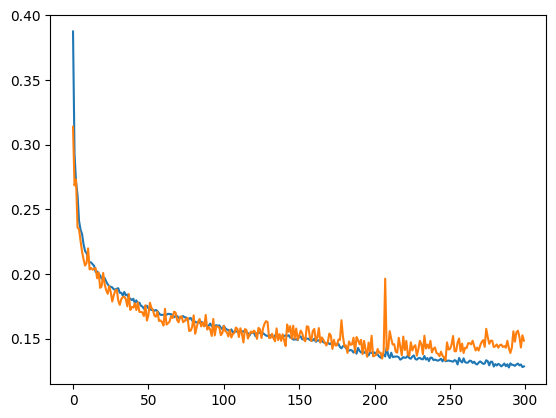

0.15044316798448562


In [22]:
# 预训练
loss_fn = nn.HuberLoss()

model = PretrainPanelTransformer(dim_raw_feature, patch_size, stride, mask_expand_size, seq_len, dim_projection, dim_temporal_embedding, dim_assets_embedding, num_bass_assets, num_head, num_layer, dropout).to('cuda:0')
model.encoder.assets_embedding.load_state_dict(torch.load('params/assets_embedding.params'))

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)


def epoch():
    train_losses = []
    model.train()
    for loader in loaders:
        for batch_x, batch_weights, batch_y in loader:
            optimizer.zero_grad()
            x_reconstructed, x_target = model(batch_x, batch_weights)
            loss = loss_fn(x_reconstructed, x_target)
            train_losses.append(loss.item()) 
            loss.backward()
            optimizer.step()
        
    test_losses = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_weights, batch_y in test_loader:
            x_reconstructed, x_target = model(batch_x, batch_weights)
            loss = loss_fn(x_reconstructed, x_target)
            test_losses.append(loss.item()) 
    return np.mean(train_losses), np.mean(test_losses)

def train(epochs = 30):
    train_losses = []
    test_losses = []
    for i in tqdm.tqdm(range(epochs)):
        train_loss, test_loss = epoch()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        scheduler.step()
        # if i > 50:
        #     if test_loss>np.mean(test_losses[-50:]):
        #         break
    plt.plot(range(epochs), train_losses)
    plt.plot(range(epochs), test_losses)
    plt.show()
    
    return np.mean(test_losses[-5:])

final_loss = train(epochs)
print(final_loss)

In [24]:
torch.save(model.encoder.state_dict(), 'params/panel_tf_backbone.params')